## Portfolio Return Analysis: Time Series Patterns and Statistical Insights

The data for this project consists of monthly observations on the prices of the largest 136 stocks in Australia from Dec 1999 to Jun 2014. 

Considering a portfolio constructed by holding <u>one share in each stock</u> in the dataset that has a price recorded at every time period. We'll use $P_{it}$ to denote the price of the $i^{\text th}$ stock at time $t$ and $P_t$ to denote the price of the portfolio at time $t$.

In [1]:
import os
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
assert os.path.isfile('./AusFirms.csv'), 'Data file Missing!'

In [3]:
file = os.path.basename('./AusFirms.csv')
ausFirms = pd.read_csv(file, parse_dates = ['date'], date_format='%m/%d/%y')

In [ ]:
ausFirms.dropna(axis=1, inplace=True)

In [7]:
print(ausFirms.shape[1])

81


#### Creating a new series called $P$ that records the portfolio value for each date. Since we have one share of each stock in the portfolio, we just need to add all the prices.

In [28]:
P= ausFirms.sum(axis=1)
P

date
1999-12-31     649.330003
2000-01-31     638.704006
2000-02-29     639.325378
2000-03-31     631.475002
2000-04-28     637.859003
                 ...     
2014-02-28    1335.335001
2014-03-31    1329.045008
2014-04-30    1331.853919
2014-05-30    1340.594982
2014-06-30    1319.470007
Length: 175, dtype: float64

#### Let's say the starting date is 1 and the ending date is $T$. For the portfolio, calculating the simple return: $\frac{P_T}{P_1}-1$; and the log return: $\log\left(\frac{P_T}{P_1 }\right)$.

In [10]:
print(f'Simple return = {(P.iloc[-1]/P.iloc[0])-1 }; Log return = {np.log( P.iloc[-1]/P.iloc[0])}')

Simple return = 1.0320484213714782; Log return = 0.709044358847417


#### Calculating the portfolio weights: $\text{w}_{it} = \frac{P_{it}}{P_t}$. 

If we use the *divide* method from Pandas, this is just one line and we will end up with a dataframe the same size as ausFirms.

In [11]:
port_weights= ausFirms.divide(P, axis=0)

#### Calculating the simple returns for each stock: $R_{it} = \frac{P_{it}}{P_{i,t-1}}-1$ and the log returns for each stock: $r_{it} = \log\frac{P_{it}}{P_{i,t-1}}$.

We only need one line for each return. To get $P_{i,t-1}$, we can use the *shift* method in Pandas.

In [12]:
sRet= ausFirms.divide(ausFirms.shift(periods=1,axis=0))-1
lRet= np.log(ausFirms.divide(ausFirms.shift(periods=1,axis=0)))

#### Now calculating the portfolio returns as follows:
- For simple returns: $R_{Pt} = w_{1,t-1}R_{1t} + w_{2,t-1}R_{2t} + \cdots + w_{n,t-1}R_{nt}$
- For log returns: $r_{Pt} = \log (w_{1,t-1}e^{r_{1t}} + w_{2,t-1}e^{r_{2t}} + \cdots + w_{n,t-1}e^{r_{nt}})$

Note: time index on the weights is one period behind the returns.

In [13]:
sRetPort= (port_weights.shift(periods=1)* sRet).sum(axis=1)
lRetPort= np.log((port_weights.shift(periods=1) * np.exp(lRet)).sum(axis=1))
lRetPort=lRetPort[1:]
sRetPort=sRetPort[1:]

C:\Users\vishw\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


#### Plotting the portfolio return series - simple and log

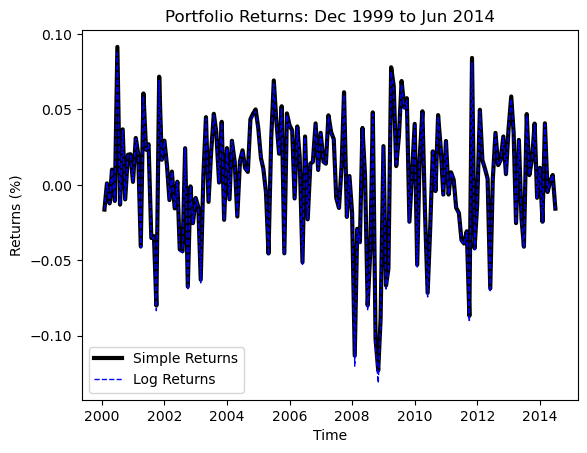

In [25]:
plt.plot(sRetPort.index, sRetPort, label='Simple Returns', linewidth=3,color='black')
plt.plot(lRetPort.index, lRetPort, label='Log Returns', linewidth=1, linestyle='dashed', color='blue')

plt.title('Portfolio Returns: Dec 1999 to Jun 2014')
plt.xlabel('Time')
plt.ylabel('Returns (%)')
plt.legend()

plt.show()

#### For each stock in the portfolio, calculating the excess kurtosis of the log returns. Then, creating a histogram of the kurtosis values.

We can use the *kurtosis* function in scipy for this. The result from this function should be an array of kurtosis values. Then, we create a histogram from this array. We can do this entire step in one line if we want to.

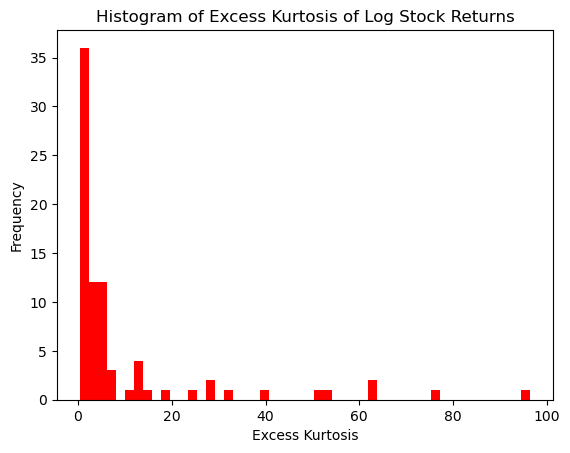

In [17]:
exKurtstock = stats.kurtosis(lRet.dropna())
plt.hist(exKurtstock, bins=50, color='red' )
plt.xlabel('Excess Kurtosis')
plt.ylabel('Frequency')
plt.title("Histogram of Excess Kurtosis of Log Stock Returns")
plt.show()

The histogram of excess kurtosis of stock returns shows an evident tail to the right making it a heavily right skewed distribution. This property is called leptokurtosis which evidences more extreme returns when compared to normal distribution as seen on the histogram. The presence of higher kurtosis suggests higher risk to the investors as it is associated with extreme outcomes.

#### Now calculating the excess kurtosis of the portfolio log return.

We should see a big difference between the kurtosis of a typical stock return and the kurtosis of the portfolio. This is one reason why portfolio returns can often be approximated using a normal distribution but individual stock returns cannot.

In [18]:
# lRetPort.kurtosis()
stats.kurtosis(lRetPort)

0.8001925120930893

#### Calculating autocorrelation function over 6 lags for the portfolio log return.

We can use the *acf* function in statsmodels to make this easy.

In [23]:
acf(lRetPort, nlags=6)

array([1.        , 0.14872526, 0.09726622, 0.17614756, 0.09995621,
       0.00225414, 0.00175506])

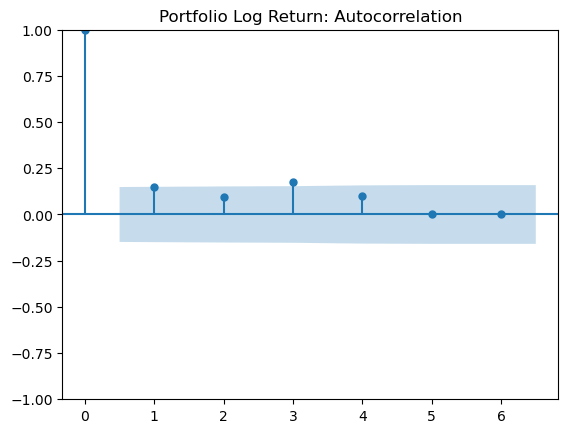

In [24]:
plot_acf(lRetPort, lags=6, title="Portfolio Log Return: Autocorrelation");

The autocorrelations for all 6 lags are clustered around 0 suggesting low autocorrelation. At a confidence level of 5%, we can see that lags 1 and 3 are slightly above the significance zone indicating they are statistically significant at this level. This suggests that there is some degree of predictability in these lags and this could potentially challenge the Efficient Market Hypothesis. 